In [2]:
from scipy.spatial import distance
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
import scipy
import math
from skimage import io
from scipy import misc


In [3]:


def display_img(im, title='default', cmap='gray'):
    """Funkcja wyświetlająca obrazek"""
    plt.figure(figsize=(8, 8))
    plt.imshow(im, cmap=cmap)
    plt.title(title)
    plt.show()



In [4]:
def series_of_transformations(im, tests=False, display_steps=False):
    test_image_small = scipy.misc.imresize(im, 0.2)
    # test_image_small = cv2.resize(test_image, (450,230))

    if not tests:
        display_img(test_image_small, 'Oryginał')
    blur = cv2.GaussianBlur(test_image_small,(5,5),0)
    # przeksztalcenie obrazka do skali szarosci
    shifted = cv2.pyrMeanShiftFiltering(blur, 40, 60)
    grey = cv2.cvtColor(shifted, cv2.COLOR_RGB2GRAY)

    if display_steps:
        display_img(grey, 'W odcieniach szarosci')

    # binaryzacja obrazka
    th, test_bin = cv2.threshold(
        grey, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    if display_steps:
        display_img(test_bin, 'Binarny')

    
    # przeksztalcenie morfologiczne - zamkniecie
    kernel = np.ones((5, 5), np.uint8)
    # closing = cv2.morphologyEx(test_bin, cv2.MORPH_CLOSE, kernel, iterations=1)
    # closing = test_bin.copy()

    
    closing = cv2.erode(test_bin,kernel,iterations = 6)
    if not tests:
        display_img(closing, 'Po erozji')
    

    # if display_steps: 
    #     display_img(closing)

    # znajdowanie tla
    kernel = np.ones((3, 3), np.uint8)
    sure_fg = cv2.dilate(closing, kernel, iterations=2)

    return sure_fg

    # Znajdowanie pewnego pierwszego planu
    dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(
        dist_transform, 0.3*dist_transform.max(), 255, 0)

    # Znajdowanie nieznanego regionu
    sure_fg = np.uint8(sure_fg)
    
    sure_fg = cv2.dilate(sure_fg,kernel,iterations = 3)

    if display_steps:
        display_img(dist_transform, 'Dist transform')
        display_img(sure_fg, 'Sure fg')

    return sure_fg



In [5]:
current_index = 0


def split(chunk, level=0):
    """ Rekurencyjna funkcja dzieląca obrazki na mniejsze części i przypisująca im indeksy """
    global current_index
    try:
        size_x = len(chunk[0])
    except IndexError:
        current_index += 1
        return current_index
    size_y = len(chunk)
    a = int(size_x / 2)
    b = int(size_y / 2)
    temp = True
    for i in range(size_y):
        for j in range(size_x):
            if(chunk[i, j] != chunk[0, 0]):
                temp = False
                break

    if not temp:
        f = partial(split, level=level+1)
        chunk[:b, :a] = f(chunk[:b, :a])
        chunk[:b, a:size_x] = f(chunk[:b, a:size_x])
        chunk[b:size_y, a:size_x] = f(chunk[b:size_y, a:size_x])
        chunk[b:size_y, :a] = f(chunk[b:size_y, :a])
        return chunk
    else:
        current_index += 1
        return np.full((size_y, size_x), current_index)


In [6]:


def merge(image, indices):
    """ Funkcja lącząca rozne indeksy nalezace do tego samego obiektu w jeden """
    LUT = np.zeros_like(image, bool)

    for y in range(len(indices)):
        # ostatni nie ustawiony
        last = None
        for x in range(len(indices[0])):

            if last is not None:
                if image[y, last] != image[y, x]:
                    for index in range(x-1, last-1, -1):
                        indices[y, index] = indices[y, last]
                    last = None

            directions = []
            if (y - 1) >= 0:
                directions.append((y-1, x))

            close_set = None
            for d in directions:
                try:  # jesli znalazlem sasiada -> zapamietuje
                    if LUT[d] and image[d] == image[y, x]:
                        close_set = d
                        break
                except IndexError:
                    pass

            if close_set is not None:
                # ustawiam index od sasiada
                indices[y, x] = indices[close_set]

                # ustawiam indeks na prawo
                try:
                    if(image[y, x+1] == image[y, x]):
                        indices[y, x+1] = indices[close_set]
                except IndexError:
                    pass

                # ustaw wszystkie poprzednie piksele
                # na ten indeks
                if last is not None:
                    for index in range(x-1, last-1, -1):
                        indices[y, index] = indices[close_set]
                    last = None

            elif last is None:
                # zapamietuje ten indeks, jesli juz nie jest zapamietany
                last = x

            LUT[y, x] = True



In [7]:
def clear_indices(indices):
    """ Funkcja przestawiająca indeksy na mniejsze wartosci, uporzadkowane rosnaco """
    copy_ind = indices.copy()

    index = 0
    while(True):
        new_tab = copy_ind[copy_ind > index]
        if(len(new_tab) == 0):
            # print('Nie ma juz wiecej indeksow')
            break
        min_index = np.amin(new_tab)

        copy_ind[copy_ind == min_index] = index
        index += 1

    return copy_ind


In [8]:


def color_objects(indices):
    """ Funkcja kolorująca wszystkie obiekty na inny kolor """
    max_index = np.amax(indices)
    # colored = np.zeros_like(image, dtype=tuple)
    colored = np.zeros((len(indices), len(indices[0]), 3), np.uint8)
    colored[indices == 0] = (0, 0, 0)
    for i in range(1, max_index+1):
        colored[indices == i] = (13 * i, 25 * i, 30 * (max_index + 1 - i))

    return colored


In [9]:


def color_index(indices, index):
    """ Funkcja kolorująca tylko dany indeks """
    colored = np.zeros((len(indices), len(indices[0]), 3), np.uint8)
    colored[indices == index] = (255, 0, 255)
    # display_img(colored, f'obiekt nr. {index}')

    return colored

def color_index_with_others(im, indices, index):
    """ Funkcja kolorująca tylko dany indeks """
    colored = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
    colored[indices == index] = (255, 0, 255)
    # display_img(colored, f'obiekt nr. {index}')

    return colored 


def get_coin_size_in_pixels(im_url):
    """ Zwraca wielkość monety w pikselach """

    if not isinstance(im_url, str):
        raise TypeError(
            f'Nie podano prawidłowego typu danych. Oczekiwano (str), a otrzymano ({type(im_url)}).')

    try:
        test_image = io.imread(im_url)
    except FileNotFoundError:
        raise ValueError('Nie podano prawidłowego pliku!')

    coin_im = series_of_transformations(test_image, tests=True)

    indices = coin_im.astype(int)

    indices = split(indices)
    indices[coin_im == 0] = -1
    merge(coin_im, indices)

    new_indices = clear_indices(indices)

    unique, counts = np.unique(new_indices, return_counts=True)
    occurances = dict(zip(unique, counts))

    return occurances[0]


In [10]:


def save_obj(obj, name):
    with open('obj/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)


In [11]:

def cog2(points):
    mx=0
    my=0
    for (y,x) in points:
        mx = mx + x
        my = my + y
    mx = mx/len(points)
    my = my/len(points)
    
    return [my, mx]



In [12]:


def compute_bb(points):
    s = len(points)
    my,mx = cog2(points)
    
    r = 0
    for point in points:
         r = r + distance.euclidean(point,(my,mx))**2
            
    return s/(math.sqrt(2*math.pi*r))


In [13]:


def compute_feret(points):
    
    px = [x for (y,x) in points]
    py = [y for (y,x) in points]
    
    fx = max(px) - min(px)
    fy = max(py) - min(py)
    
    return float(fy)/float(fx)  

def get_points(indices, index):
    points = []

    for y in range(len(indices)):
        for x in range(len(indices[0])):
            if indices[y, x] == index:
                points.append((y, x))

    return points


In [14]:

def count_haralick(centroid, contours):
    n = len(contours)
    my, mx = centroid
    a1 = 0
    a2 = 0
    for i in range(n):
        a1 += distance.euclidean((contours[i][0][1], contours[i][0][0]),(my,mx))
        a2 += (distance.euclidean((contours[i][0][1], contours[i][0][0]),(my,mx))**2 - 1)
    return math.sqrt((a1**2)/(n*a2))


In [15]:


def count_coins(im_url, tests=False, display_steps=False):
    """Funkcja przekształcająca obrazek i licząca ile monet znajduje sie na obrazku"""
    if not isinstance(im_url, str):
        raise TypeError(
            f'Nie podano prawidłowego typu danych. Oczekiwano (str), a otrzymano ({type(im_url)}).')

    global current_index
    current_index = 0

    if tests:
        display_steps = False
    # załadowanie oryginalnego obrazka
    # test_image = io.imread('test_rozdzielnie.jpg')
    #test_image = io.imread('img/Obraz (11).jpg')

    try:
        test_image = io.imread(im_url)
    except FileNotFoundError:
        raise ValueError('Nie podano prawidłowego pliku!')

    #test_image_small = cv2.resize(test_image,None,fx=0.2,fy=0.2)

    sure_fg = series_of_transformations(
        test_image, tests=tests, display_steps=display_steps)

    # count = splitting(sure_fg)
    indices = sure_fg.astype(int)
    # indices = sure_fg.copy()

    indices = split(indices)
    # print(indices)
    indices[sure_fg == 0] = -1
    merge(sure_fg, indices)
    # ustawianie tla na zerowy indeks

    # czyszczenie indeksow
    new_indices = clear_indices(indices)

    # new_image = color_objects(image, new_indices)

    count = len(np.unique(new_indices)) - 1

    unique, counts = np.unique(new_indices, return_counts=True)
    occurances = dict(zip(unique, counts))
    print(occurances)

    global coins_sizes

    suma = 0
    for k in occurances:
        if k == -1:
            continue
        coin = color_index_with_others(sure_fg, new_indices, k)
        if not tests:
            display_img(coin, f'Moneta nr {k}')
        key = min(coins_sizes, key=lambda x: abs(coins_sizes[x]-occurances[k]))
        print(f'Obiekt nr {k}')  # to {key}')
        print(f'Moneta {key}')
        suma+=coins_amm[key]
        whole_space = len(sure_fg[0]) * len(sure_fg)
        ob_space = occurances[k]
        print(f'Zajmuje {ob_space/whole_space * 100}% calego obrazka')
        points = get_points(new_indices, k)
        cog = cog2(points)
        print(f'Srodek ciezkosci: {cog}')
        print(f'Blair-Bliss: {compute_bb(points)}')
        print(f'Feret: {compute_feret(points)}')
        # print(occurances[k])
        # print(len(points))


        x = 0
        tab = []
        while x < len(unique):
            _, cnts, _ = cv2.findContours(np.uint8(sure_fg[new_indices==k]), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            for c in cnts:
                tab.append(c)
            x += 1

        print(f'Haralick: {count_haralick(cog, tab[k])}')

    suma = round(suma, 2)
    print(f'Wykryto {count} obiekty/ów na obrazie')
    print(f'Suma nominalów: {suma}')

    return count, suma



In [16]:

try:
    coins_sizes = load_obj('coins_sizes')
except (OSError, IOError) as e:
    coins_sizes = {
        "5zl": get_coin_size_in_pixels("img/5.jpg"),
        "2zl": get_coin_size_in_pixels("img/2.jpg"),
        "1zl": get_coin_size_in_pixels("img/1.jpg"),
        "50gr": get_coin_size_in_pixels("img/50gr.jpg"),
        "20gr": get_coin_size_in_pixels("img/20gr.jpg"),
        "10gr": get_coin_size_in_pixels("img/10gr.jpg"),
        "5gr": get_coin_size_in_pixels("img/5gr.jpg"),
        "2gr": get_coin_size_in_pixels("img/2gr.jpg"),
        "1gr": get_coin_size_in_pixels("img/1gr.jpg"),
    }

    save_obj(coins_sizes, 'coins_sizes')

coins_amm = {
    "5zl": 5,
    "2zl": 2,
    "1zl": 1,
    "50gr": 0.5,
    "20gr": 0.2,
    "10gr": 0.1,
    "5gr": 0.05,
    "2gr": 0.02,
    "1gr": 0.01
}



{'5zl': 733, '2zl': 478, '1zl': 619, '50gr': 344, '20gr': 221, '10gr': 88, '5gr': 270, '2gr': 137, '1gr': 52}


C:\Users\Szymo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


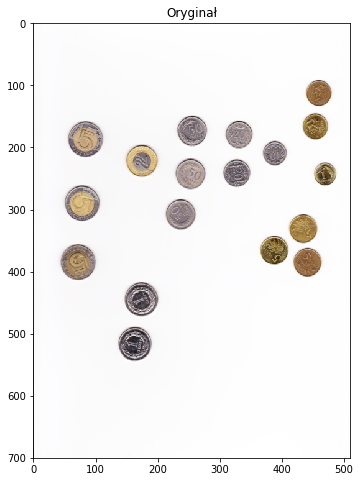

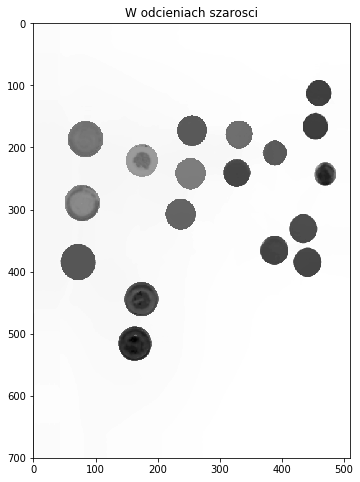

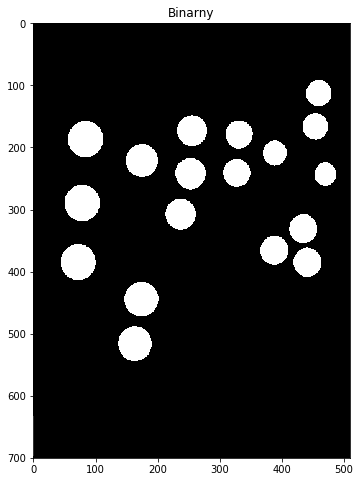

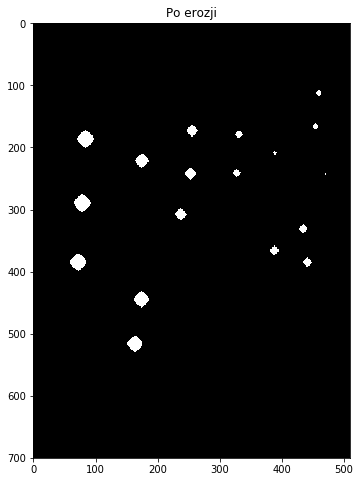

{-1: 350240, 0: 739, 1: 371, 2: 503, 3: 387, 4: 382, 5: 751, 6: 225, 7: 153, 8: 149, 9: 94, 10: 45, 11: 256, 12: 214, 13: 264, 14: 263, 15: 719, 16: 625, 17: 620}


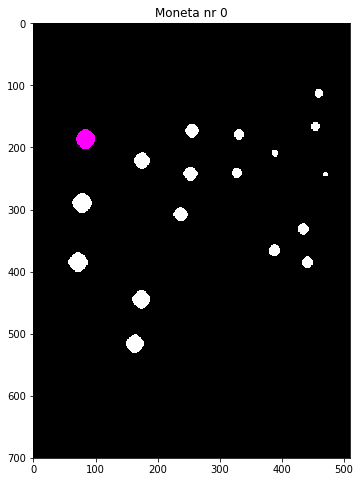

Obiekt nr 0
Moneta 5zl
Zajmuje 0.20700280112044817% calego obrazka
Srodek ciezkosci: [186.16779431664412, 84.063599458728]
Blair-Bliss: 0.9969003379475502
Feret: 1.0666666666666667
Haralick: 0.8673005690492902


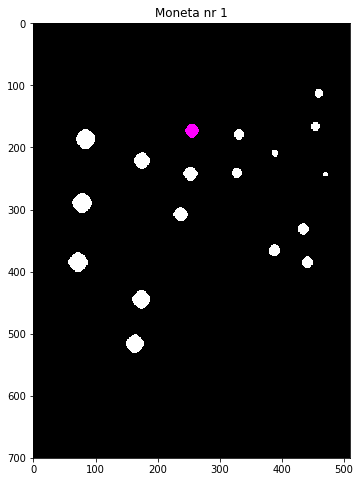

Obiekt nr 1
Moneta 50gr
Zajmuje 0.10392156862745099% calego obrazka
Srodek ciezkosci: [172.78975741239893, 255.51752021563343]
Blair-Bliss: 0.9968652056153101
Feret: 1.0476190476190477
Haralick: 0.9977481330477472


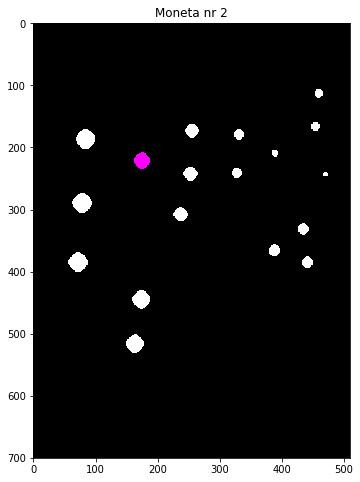

Obiekt nr 2
Moneta 2zl
Zajmuje 0.14089635854341737% calego obrazka
Srodek ciezkosci: [221.03777335984094, 174.64811133200794]
Blair-Bliss: 0.9969425674782245
Feret: 1.04
Haralick: 0.9820709007157961


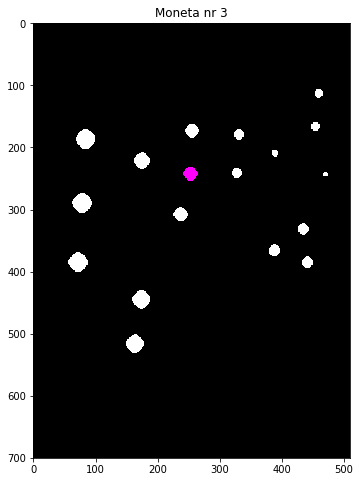

Obiekt nr 3
Moneta 50gr
Zajmuje 0.10840336134453782% calego obrazka
Srodek ciezkosci: [241.87596899224806, 252.91472868217053]
Blair-Bliss: 0.9968318495331763
Feret: 1.0
Haralick: 0.9955392143806011


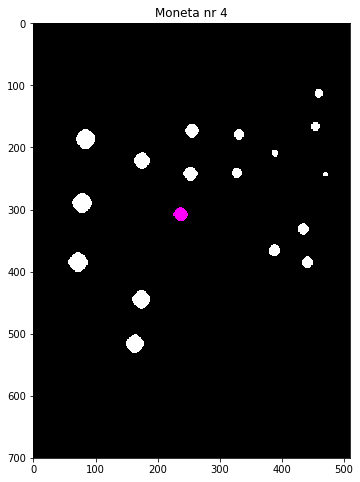

Obiekt nr 4
Moneta 50gr
Zajmuje 0.10700280112044817% calego obrazka
Srodek ciezkosci: [307.19633507853405, 237.18324607329842]
Blair-Bliss: 0.9971078700484223
Feret: 1.0
Haralick: 0.9868542287730835


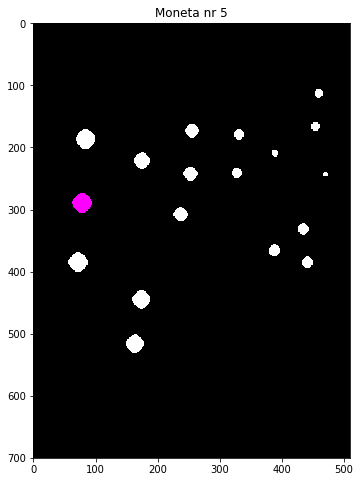

Obiekt nr 5
Moneta 5zl
Zajmuje 0.2103641456582633% calego obrazka
Srodek ciezkosci: [289.15446071904125, 78.67376830892144]
Blair-Bliss: 0.996621561827195
Feret: 1.032258064516129
Haralick: 0.8944774396219592


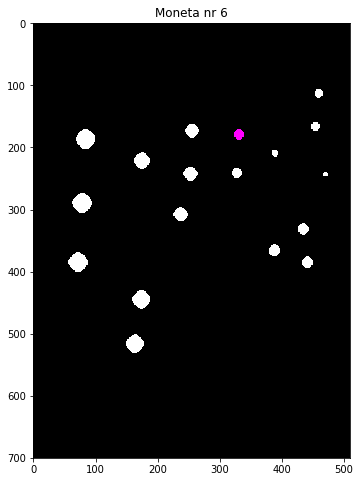

Obiekt nr 6
Moneta 20gr
Zajmuje 0.06302521008403361% calego obrazka
Srodek ciezkosci: [178.5911111111111, 330.9822222222222]
Blair-Bliss: 0.9961075908406137
Feret: 1.0625
Haralick: 0.9992407992811752


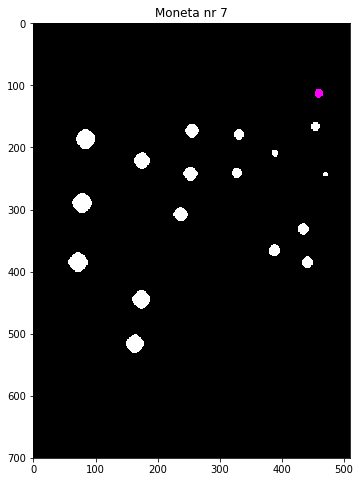

Obiekt nr 7
Moneta 2gr
Zajmuje 0.04285714285714286% calego obrazka
Srodek ciezkosci: [112.45751633986929, 459.48366013071893]
Blair-Bliss: 1.0001980179639771
Feret: 1.0
Haralick: 0.9999667317547245


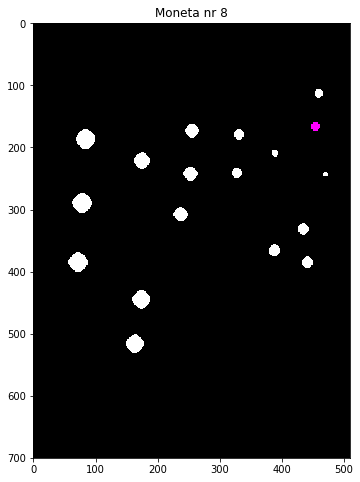

Obiekt nr 8
Moneta 2gr
Zajmuje 0.041736694677871146% calego obrazka
Srodek ciezkosci: [165.74496644295303, 453.9597315436242]
Blair-Bliss: 0.9990577345860518
Feret: 1.0833333333333333
Haralick: 0.9998325450632453


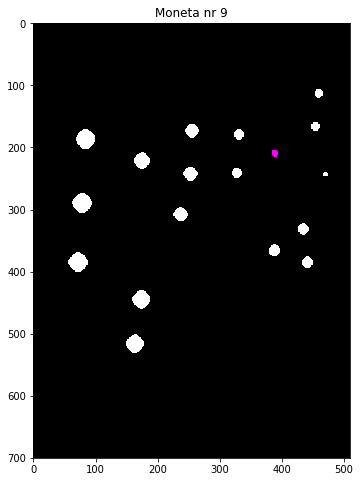

Obiekt nr 9
Moneta 10gr
Zajmuje 0.026330532212885158% calego obrazka
Srodek ciezkosci: [208.8404255319149, 388.56382978723406]
Blair-Bliss: 0.9980748497853914
Feret: 1.1111111111111112
Haralick: 0.9997025824085177


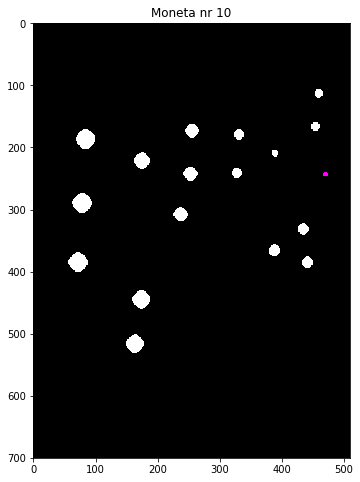

Obiekt nr 10
Moneta 1gr
Zajmuje 0.012605042016806723% calego obrazka
Srodek ciezkosci: [243.0, 470.0]
Blair-Bliss: 1.0035698153359338
Feret: 1.0
Haralick: 0.9999477029045377


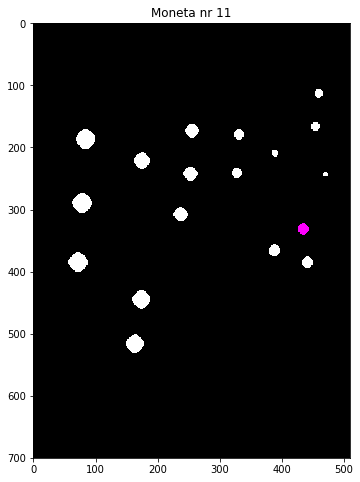

Obiekt nr 11
Moneta 5gr
Zajmuje 0.07170868347338935% calego obrazka
Srodek ciezkosci: [330.8359375, 434.31640625]
Blair-Bliss: 0.9976068778290167
Feret: 1.0588235294117647
Haralick: 0.9979640679817252


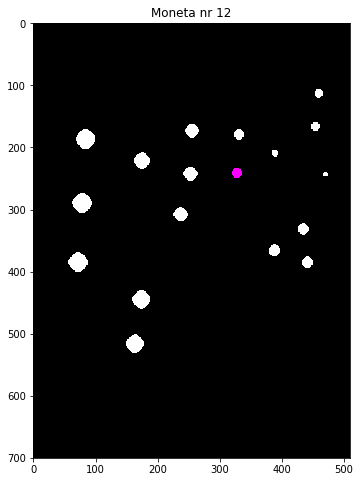

Obiekt nr 12
Moneta 20gr
Zajmuje 0.05994397759103642% calego obrazka
Srodek ciezkosci: [240.90654205607476, 327.43457943925233]
Blair-Bliss: 0.9989004354553255
Feret: 1.0666666666666667
Haralick: 0.9979193004146281


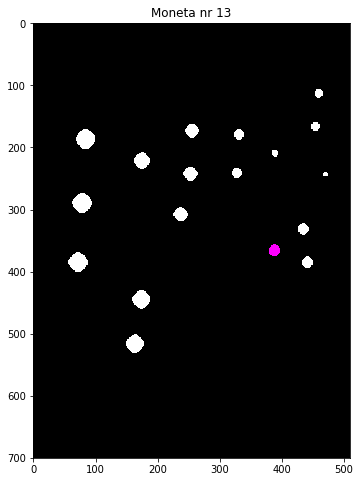

Obiekt nr 13
Moneta 5gr
Zajmuje 0.07394957983193277% calego obrazka
Srodek ciezkosci: [365.3712121212121, 387.7386363636364]
Blair-Bliss: 0.9973008298785638
Feret: 1.0588235294117647
Haralick: 0.9964385789594397


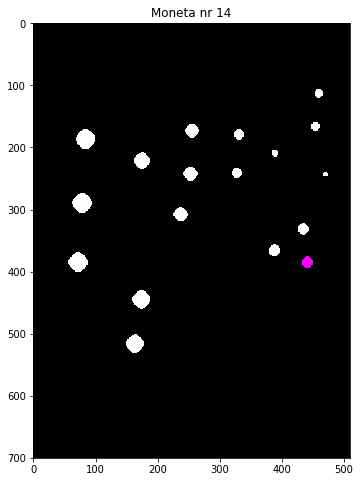

Obiekt nr 14
Moneta 5gr
Zajmuje 0.07366946778711485% calego obrazka
Srodek ciezkosci: [384.56273764258555, 441.212927756654]
Blair-Bliss: 0.9944954549805614
Feret: 1.1176470588235294
Haralick: 0.9973666319613869


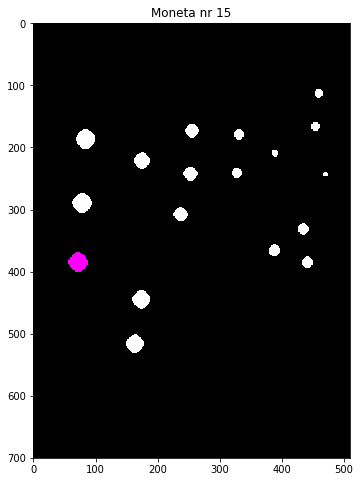

Obiekt nr 15
Moneta 5zl
Zajmuje 0.20140056022408961% calego obrazka
Srodek ciezkosci: [384.3588317107093, 72.20723226703755]
Blair-Bliss: 0.997393180264338
Feret: 1.0333333333333334
Haralick: 0.9084862188739594


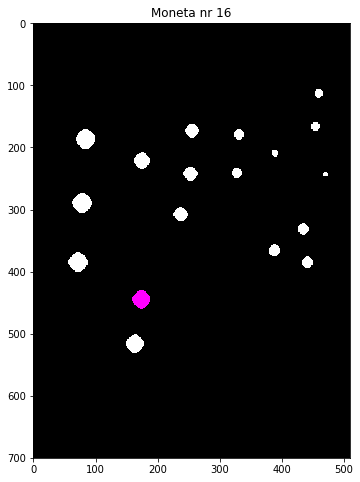

Obiekt nr 16
Moneta 1zl
Zajmuje 0.1750700280112045% calego obrazka
Srodek ciezkosci: [444.1024, 173.9168]
Blair-Bliss: 0.9952787705144027
Feret: 1.0714285714285714
Haralick: 0.947143710700647


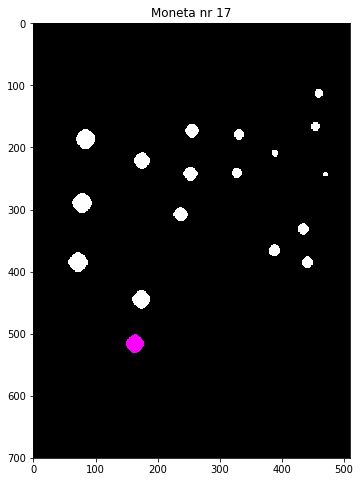

Obiekt nr 17
Moneta 1zl
Zajmuje 0.17366946778711484% calego obrazka
Srodek ciezkosci: [515.7306451612903, 163.55645161290323]
Blair-Bliss: 0.9971689281879293
Feret: 1.0740740740740742
Haralick: 0.926366084901536
Wykryto 18 obiekty/ów na obrazie
Suma nominalów: 21.2


(18, 21.2)

In [17]:
print(coins_sizes)

count_coins('img/monety10.jpg',  display_steps=True)
